In [8]:
import os
import pandas as pd
import librosa
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt


In [9]:
DATA_PATH = r"C:\Users\nasrr\Desktop\CNN_Farah\Farah\ESC-50-master\ESC-50-master"
AUDIO_PATH = os.path.join(DATA_PATH, "audio")
CSV_PATH = os.path.join(DATA_PATH, "meta", "esc50.csv")

In [10]:
df = pd.read_csv(CSV_PATH)
print(df.head())  # See the structure

            filename  fold  target        category  esc10  src_file take
0   1-100032-A-0.wav     1       0             dog   True    100032    A
1  1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
2  1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
3  1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
4  1-101296-A-19.wav     1      19    thunderstorm  False    101296    A


In [11]:
def augment_audio(y, sr):
    # Resample to slightly different rate to simulate time stretch
    if np.random.rand() < 0.5:
        stretch_rate = np.random.uniform(0.8, 1.2)
        y = librosa.resample(y, orig_sr=sr, target_sr=int(sr * stretch_rate))

    # Simulate pitch shift by resampling after speed change
    if np.random.rand() < 0.5:
        pitch_factor = np.random.uniform(0.9, 1.1)
        y = librosa.resample(y, orig_sr=sr, target_sr=int(sr * pitch_factor))

    # Add Gaussian noise
    if np.random.rand() < 0.5:
        noise_amp = 0.005 * np.random.uniform() * np.amax(y)
        y += noise_amp * np.random.normal(size=y.shape)

    return y


In [12]:
def extract_mel_spectrogram(file_path, sr=22050, n_mels=128, augment=False):
    y, sr = librosa.load(file_path, sr=sr)

    # Apply augmentation only if specified
    if augment:
        y = augment_audio(y, sr)

    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    mel_db = librosa.power_to_db(mel, ref=np.max)

    return mel_db


In [13]:
mel_specs = []
labels = []

apply_augmentation = True  # Set to False for validation

for idx, row in tqdm(df.iterrows(), total=len(df)):
    file_name = row['filename']
    label = row['target']
    full_path = os.path.join(AUDIO_PATH, file_name)

    mel = extract_mel_spectrogram(full_path, augment=apply_augmentation)

    # Ensure fixed shape (128, 216)
    if mel.shape[1] < 216:
        mel = np.pad(mel, ((0, 0), (0, 216 - mel.shape[1])), mode='constant')
    else:
        mel = mel[:, :216]

    mel_specs.append(mel)
    labels.append(label)

mel_specs = np.stack(mel_specs)
labels = np.array(labels)

print("Final shape:", mel_specs.shape)  # Expected: (samples, 128, 216)


100%|██████████| 2000/2000 [00:21<00:00, 92.51it/s] 


Final shape: (2000, 128, 216)


Class: dog, Shape: (128, 216)


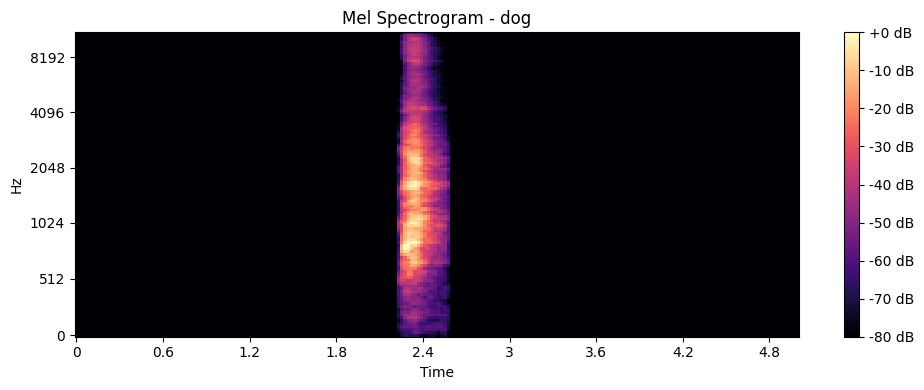

Class: chirping_birds, Shape: (128, 216)


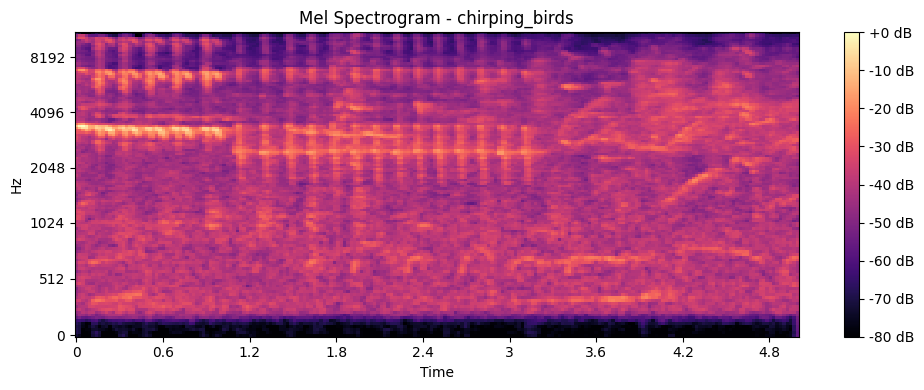

Class: vacuum_cleaner, Shape: (128, 216)


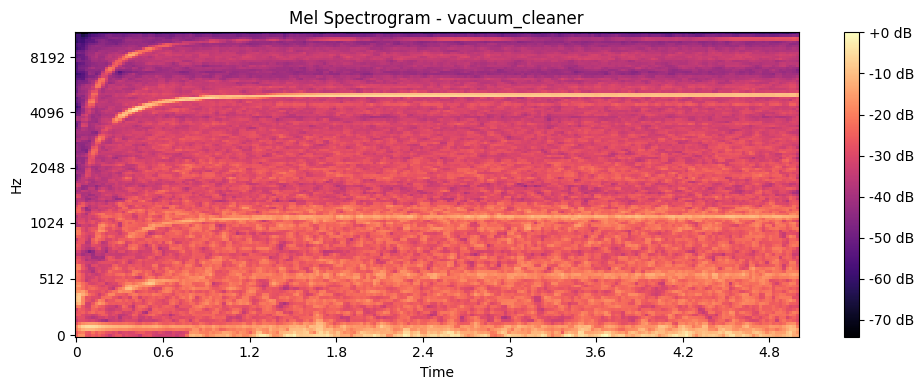

In [14]:
# Try a few examples first
for idx in range(3):
    row = df.iloc[idx]
    file_name = row['filename']
    category = row['category']
    full_path = os.path.join(AUDIO_PATH, file_name)

    mel_spec = extract_mel_spectrogram(full_path)

    print(f"Class: {category}, Shape: {mel_spec.shape}")
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(mel_spec, sr=22050, x_axis='time', y_axis='mel')
    plt.title(f"Mel Spectrogram - {category}")
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()


In [15]:
import torch
from torch.utils.data import Dataset

class ESC50MelDataset(Dataset):
    def __init__(self, mel_specs, labels):
        self.mel_specs = mel_specs
        self.labels = labels

    def __len__(self):
        return len(self.mel_specs)

    def __getitem__(self, idx):
        # Add channel dimension: (1, 128, 216)
        x = torch.tensor(self.mel_specs[idx], dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(self.labels[idx], dtype=torch.long)
        return x, y


In [16]:
import torch.nn as nn
import torch.nn.functional as F

class ESC50_CNN_Deep(nn.Module):
    def __init__(self, num_classes=50):
        super(ESC50_CNN_Deep, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.05)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.05)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )

        # After 4 poolings: (128, 216) → (8, 13)
        self.fc1 = nn.Linear(128 * 8 * 13, 256)
        self.dropout_fc = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)  # → (32, 64, 108)
        x = self.conv_block2(x)  # → (64, 32, 54)
        x = self.conv_block3(x)  # → (128, 16, 27)
        x = self.conv_block4(x)  # → (128, 8, 13)
        x = x.view(x.size(0), -1)
        x = self.dropout_fc(F.relu(self.fc1(x)))
        return self.fc2(x)


In [17]:
import torch.nn as nn
import torch.nn.functional as F

class ESC50_CNN_Deep_6Layers(nn.Module):
    def __init__(self, num_classes=50):
        super(ESC50_CNN_Deep_6Layers, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.05)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )

        self.conv_block5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.15)
        )

        self.conv_block6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        # After 6 poolings: (128x216) → (2, 3)
        self.fc1 = nn.Linear(256 * 2 * 3, 256)
        self.dropout_fc = nn.Dropout(0.3)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.conv_block1(x)  # → (32, 64, 108)
        x = self.conv_block2(x)  # → (64, 32, 54)
        x = self.conv_block3(x)  # → (128, 16, 27)
        x = self.conv_block4(x)  # → (128, 8, 13)
        x = self.conv_block5(x)  # → (256, 4, 6)
        x = self.conv_block6(x)  # → (256, 2, 3)

        x = x.view(x.size(0), -1)
        x = self.dropout_fc(F.relu(self.fc1(x)))
        return self.fc2(x)


In [18]:
import torch.nn as nn

class ESC50_CNN_Deep_8Layers(nn.Module):
    def __init__(self, num_classes=50):
        super(ESC50_CNN_Deep_8Layers, self).__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.05)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.05)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )

        self.conv_block4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1)
        )

        self.conv_block5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.15)
        )

        self.conv_block6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )

        self.conv_block7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        self.conv_block8 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.25)
        )

        self.fc_block = nn.Sequential(
            nn.Linear(256 * 2 * 3, 1024),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)
        x = self.conv_block6(x)
        x = self.conv_block7(x)
        x = self.conv_block8(x)

        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return x


In [19]:
import tensorflow as tf
import tensorflow_hub as hub

# Load YAMNet model
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

In [20]:
def load_audio(filepath):
    # YAMNet expects 16 kHz mono audio
    waveform, sr = librosa.load(filepath, sr=16000, mono=True)
    return waveform


In [5]:
def extract_yamnet_embedding(waveform):
    scores, embeddings, spectrogram = yamnet_model(waveform)
    return embeddings.numpy().mean(axis=0)  # (1024,)

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

audio_dir = 'audio/'  # Path to the folder containing .wav files

X = []
y = []

# Process each file
for i, row in tqdm(df.iterrows(), total=len(df)):
    filepath = os.path.join(audio_dir, row['filename'])

    try:
        # Load audio as 16kHz mono
        waveform, sr = librosa.load(filepath, sr=16000, mono=True)
        waveform = tf.convert_to_tensor(waveform, dtype=tf.float32)

        # Run through YAMNet to get embeddings
        _, embeddings, _ = yamnet_model(waveform)
        embedding_mean = tf.reduce_mean(embeddings, axis=0).numpy()  # (1024,)

        X.append(embedding_mean)
        y.append(row['target'])

    except Exception as e:
        print(f"Failed to process {filepath}: {e}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_val)
print("Validation Accuracy:", accuracy_score(y_val, y_pred) * 100)


  0%|          | 0/2000 [00:00<?, ?it/s]C:\Users\nasrr\AppData\Local\Temp\ipykernel_16632\272055824.py:16: UserWarning: PySoundFile failed. Trying audioread instead.
  waveform, sr = librosa.load(filepath, sr=16000, mono=True)
c:\Users\nasrr\Desktop\myenv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 60%|█████▉    | 1197/2000 [00:00<00:00, 6093.06it/s]

Failed to process audio/1-100032-A-0.wav: [Errno 2] No such file or directory: 'audio/1-100032-A-0.wav'
Failed to process audio/1-100038-A-14.wav: [Errno 2] No such file or directory: 'audio/1-100038-A-14.wav'
Failed to process audio/1-100210-A-36.wav: [Errno 2] No such file or directory: 'audio/1-100210-A-36.wav'
Failed to process audio/1-100210-B-36.wav: [Errno 2] No such file or directory: 'audio/1-100210-B-36.wav'
Failed to process audio/1-101296-A-19.wav: [Errno 2] No such file or directory: 'audio/1-101296-A-19.wav'
Failed to process audio/1-101296-B-19.wav: [Errno 2] No such file or directory: 'audio/1-101296-B-19.wav'
Failed to process audio/1-101336-A-30.wav: [Errno 2] No such file or directory: 'audio/1-101336-A-30.wav'
Failed to process audio/1-101404-A-34.wav: [Errno 2] No such file or directory: 'audio/1-101404-A-34.wav'
Failed to process audio/1-103298-A-9.wav: [Errno 2] No such file or directory: 'audio/1-103298-A-9.wav'
Failed to process audio/1-103995-A-30.wav: [Errno 

100%|██████████| 2000/2000 [00:00<00:00, 6048.69it/s]


Failed to process audio/3-98193-A-46.wav: [Errno 2] No such file or directory: 'audio/3-98193-A-46.wav'
Failed to process audio/3-98771-A-18.wav: [Errno 2] No such file or directory: 'audio/3-98771-A-18.wav'
Failed to process audio/3-98869-A-46.wav: [Errno 2] No such file or directory: 'audio/3-98869-A-46.wav'
Failed to process audio/4-102844-A-49.wav: [Errno 2] No such file or directory: 'audio/4-102844-A-49.wav'
Failed to process audio/4-102844-B-49.wav: [Errno 2] No such file or directory: 'audio/4-102844-B-49.wav'
Failed to process audio/4-102844-C-49.wav: [Errno 2] No such file or directory: 'audio/4-102844-C-49.wav'
Failed to process audio/4-102871-A-42.wav: [Errno 2] No such file or directory: 'audio/4-102871-A-42.wav'
Failed to process audio/4-107117-A-33.wav: [Errno 2] No such file or directory: 'audio/4-107117-A-33.wav'
Failed to process audio/4-107120-A-33.wav: [Errno 2] No such file or directory: 'audio/4-107120-A-33.wav'
Failed to process audio/4-107122-A-33.wav: [Errno 2]

ValueError: With n_samples=0, test_size=0.2 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
from torch.utils.data import DataLoader, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Create dataset
dataset = ESC50MelDataset(mel_specs, labels)

# Split dataset
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

# Loaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ESC50_CNN_Deep_8Layers().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)
criterion = nn.CrossEntropyLoss()

epochs_count = 50

# Training loop
for epoch in range(epochs_count):
    model.train()
    total_loss = 0
    correct = 0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        correct += (outputs.argmax(1) == targets).sum().item()

    train_acc = 100.0 * correct / len(train_ds)

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss = 0.0

    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == targets).sum().item()
            val_total += targets.size(0)

    val_acc = 100.0 * val_correct / val_total
    val_loss /= len(val_loader)

    print(f"Epoch {epoch+1}, Train Loss: {total_loss:.2f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.2f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model if validation accuracy improves
    if epoch == 0:
        best_val_acc = val_acc

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
        print(f"✅ Saved new best model at epoch {epoch+1} with Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_acc)
    for param_group in optimizer.param_groups:
        print(f"Current Learning Rate: {param_group['lr']:.6f}")

c:\Users\nasrr\Desktop\myenv\lib\site-packages\torch\hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(


HTTPError: HTTP Error 404: Not Found

In [119]:
%pip install torchaudio librosa

Note: you may need to restart the kernel to use updated packages.


In [107]:
model.eval()
correct = 0
with torch.no_grad():
    for inputs, targets in val_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        correct += (outputs.argmax(1) == targets).sum().item()

val_acc = 100.0 * correct / len(val_ds)

print(f"Validation Accuracy: {val_acc:.2f}%")


Validation Accuracy: 68.50%
